In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install ultralytics torch torchvision opencv-python pillow albumentations
!pip install matplotlib seaborn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.7 MB/s eta 0:00:00


In [3]:
#Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix
import random
import shutil
from pathlib import Path
%ls

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
drive/  sample_data/


In [18]:
#Define paths and classes
class Config:
    DATA_PATH = "drive/MyDrive/data"
    OUTPUT_PATH = "drive/MyDrive/weather_classification"
    RUNS_PATH = "drive/MyDrive/runs"
    CLASSES = ['cloudy', 'foggy', 'rainy', 'snowy', 'sunny']
    IMG_SIZE = 640
    BATCH_SIZE = 16
    EPOCHS = 2 #50 objective
    PRETRAINED_MODEL = 'yolo11n.pt'  # pre trained model use yolo11s.pt, yolo11m.pt

config = Config()

#Create directory structure
def setup_directories():
    os.makedirs(config.OUTPUT_PATH, exist_ok=True)
    os.makedirs(os.path.join(config.OUTPUT_PATH, "images", "train"), exist_ok=True)
    os.makedirs(os.path.join(config.OUTPUT_PATH, "images", "val"), exist_ok=True)
    os.makedirs(os.path.join(config.OUTPUT_PATH, "labels", "train"), exist_ok=True)
    os.makedirs(os.path.join(config.OUTPUT_PATH, "labels", "val"), exist_ok=True)

setup_directories()

In [5]:
#Data augmentation functions
import albumentations as A

def create_augmentation_pipeline():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.HueSaturationValue(p=0.3),
        A.RandomGamma(p=0.2),
        A.CLAHE(p=0.2),
        A.RandomRotate90(p=0.3),
        A.Transpose(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.3),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
        A.Blur(blur_limit=3, p=0.2),
    ])

augmentation = create_augmentation_pipeline()

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-236209624.py:14: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),


In [11]:
# Convert classification dataset to YOLO format with augmentation
def convert_to_yolo_format():
    # Create dataset.yaml file
    yaml_content = f"""
path: {os.path.abspath(config.OUTPUT_PATH)}
train: images/train
val: images/val

nc: {len(config.CLASSES)}
names: {config.CLASSES}
"""

    with open(os.path.join(config.OUTPUT_PATH, "dataset.yaml"), "w") as f:
        f.write(yaml_content)

    # Process each class
    for class_idx, class_name in enumerate(config.CLASSES):
        class_path = os.path.join(config.DATA_PATH, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Split data (80% train, 20% validation)
        random.shuffle(images)
        split_idx = int(0.8 * len(images))
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        # Process training images (with augmentation)
        for img_name in train_images:
            img_path = os.path.join(class_path, img_name)
            image = cv2.imread(img_path)
            if image is None:
                continue

            # Original image
            save_image_and_label(image, img_name, class_idx, "train")

            # Augmented images (create 2 additional versions)
            for aug_idx in range(2):
                augmented = augmentation(image=image)['image']
                aug_name = f"aug_{aug_idx}_{img_name}"
                save_image_and_label(augmented, aug_name, class_idx, "train")

        # Process validation images (no augmentation)
        for img_name in val_images:
            img_path = os.path.join(class_path, img_name)
            image = cv2.imread(img_path)
            if image is None:
                continue
            save_image_and_label(image, img_name, class_idx, "val")

def save_image_and_label(image, img_name, class_idx, split):
    # Save image
    img_save_path = os.path.join(config.OUTPUT_PATH, "images", split, img_name)
    cv2.imwrite(img_save_path, image)

    # Create YOLO format label (single class for whole image)
    label_save_path = os.path.join(config.OUTPUT_PATH, "labels", split,
                                  os.path.splitext(img_name)[0] + ".txt")

    # YOLO format: class_id x_center y_center width height
    # For classification, we use the entire image as bounding box
    height, width = image.shape[:2]
    x_center = 0.5
    y_center = 0.5
    bbox_width = 1.0
    bbox_height = 1.0

    with open(label_save_path, "w") as f:
        f.write(f"{class_idx} {x_center} {y_center} {bbox_width} {bbox_height}")

# Convert the dataset
convert_to_yolo_format()
print("Dataset conversion completed!")

KeyboardInterrupt: 

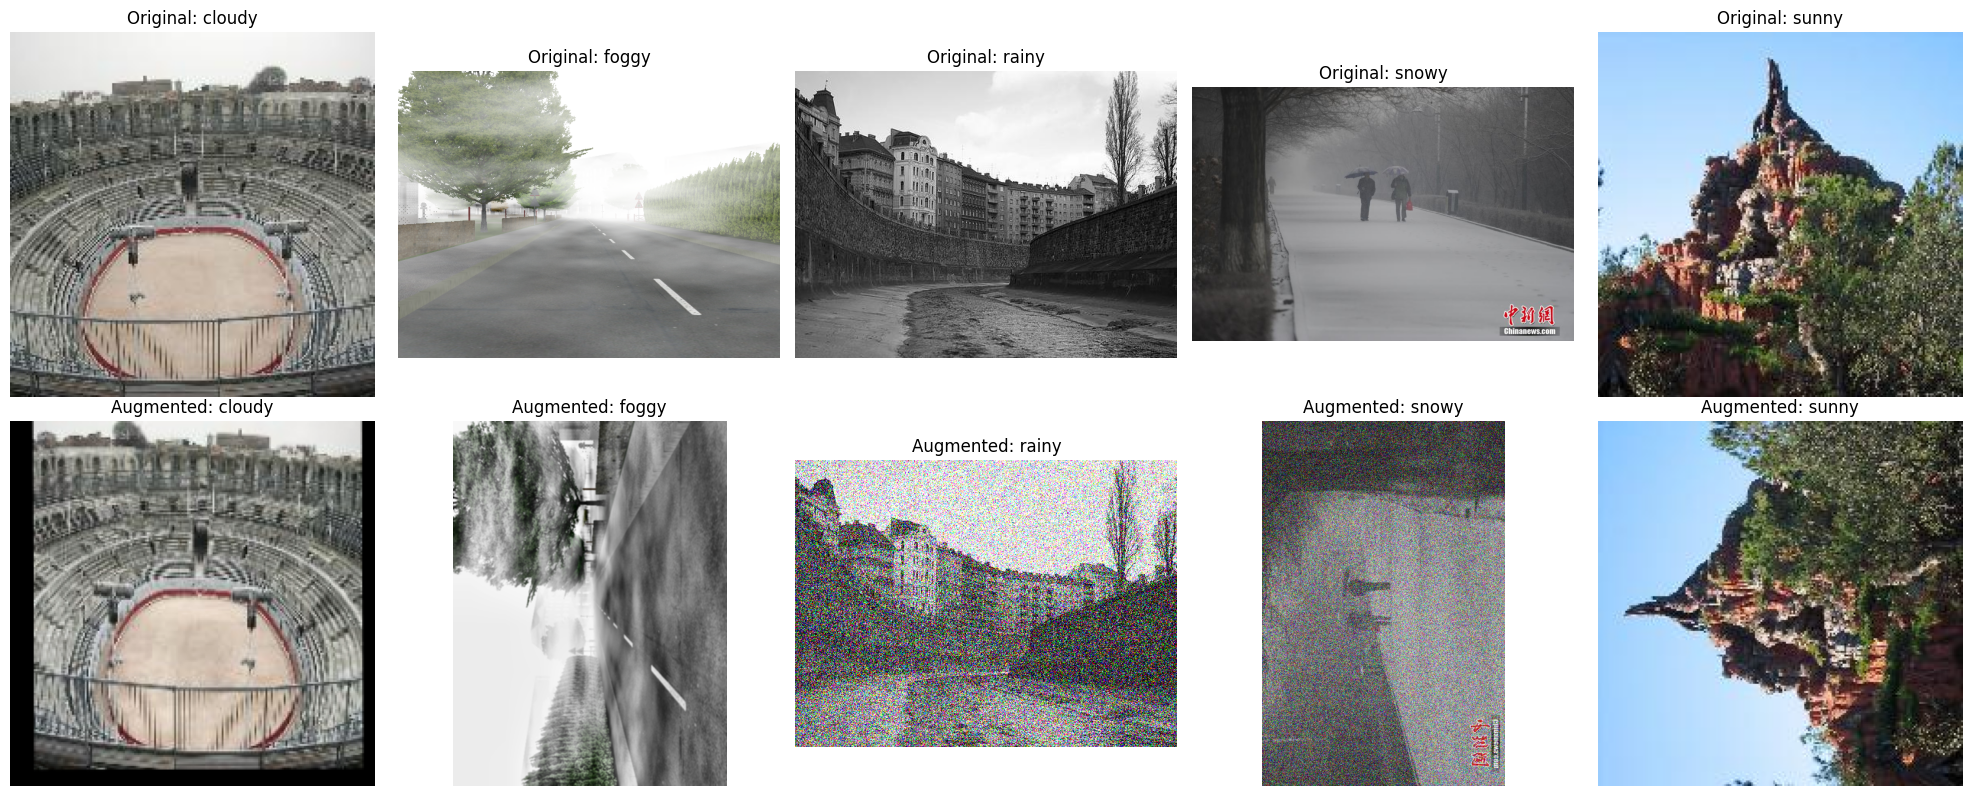

In [12]:
# Visualize some samples with augmentation
def visualize_samples():
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    for i, class_name in enumerate(config.CLASSES):
        class_path = os.path.join(config.DATA_PATH, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if images:
            # Original image
            img_path = os.path.join(class_path, images[0])
            original_img = cv2.imread(img_path)
            original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

            # Augmented image
            augmented_img = augmentation(image=original_img)['image']

            axes[0, i].imshow(original_img)
            axes[0, i].set_title(f'Original: {class_name}')
            axes[0, i].axis('off')

            axes[1, i].imshow(augmented_img)
            axes[1, i].set_title(f'Augmented: {class_name}')
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples()

In [13]:
# Initialize YOLO model
def setup_model():
    model = YOLO(config.PRETRAINED_MODEL)
    return model

model = setup_model()
print("Model loaded successfully!")

Model loaded successfully!


In [14]:
# Train the model
def train_model():
    results = model.train(
        data=os.path.join(config.OUTPUT_PATH, "dataset.yaml"),
        epochs=config.EPOCHS,
        imgsz=config.IMG_SIZE,
        batch=config.BATCH_SIZE,
        patience=10,
        save=True,
        device=0 if torch.cuda.is_available() else 'cpu',
        workers=4,
        lr0=0.01,  # Initial learning rate
        lrf=0.01,  # Final learning rate factor
        momentum=0.937,
        weight_decay=0.0005,
        warmup_epochs=3.0,
        box=7.5,   # Box loss gain
        cls=0.5,   # Class loss gain
        hsv_h=0.015,  # Image HSV-Hue augmentation
        hsv_s=0.7,    # Image HSV-Saturation augmentation
        hsv_v=0.4,    # Image HSV-Value augmentation
        degrees=0.0,  # Image rotation
        translate=0.1,  # Image translation
        scale=0.5,     # Image scale
        shear=0.0,     # Image shear
        perspective=0.0,  # Image perspective
        flipud=0.0,    # Image flip up-down
        fliplr=0.5,    # Image flip left-right
        mosaic=1.0,    # Image mosaic
        mixup=0.0,     # Image mixup
        copy_paste=0.0,  # Segment copy-paste
    )
    return results

training_results = train_model()

Ultralytics 8.3.218 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=drive/MyDrive/weather_classification/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=2, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, p

In [19]:
# Evaluate the model
def evaluate_model():
    # Load the best model from training
    best_model_path = config.RUNS_PATH+"/detect/train/weights/best.pt"
    model = YOLO(best_model_path)

    # Validate on validation set
    metrics = model.val(
        data=os.path.join(config.OUTPUT_PATH, "dataset.yaml"),
        split='val',
        imgsz=config.IMG_SIZE,
        batch=config.BATCH_SIZE,
        conf=0.25,
        iou=0.45
    )

    return metrics, model

metrics, best_model = evaluate_model()
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")

Ultralytics 8.3.218 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 24.1±19.0 MB/s, size: 33.8 KB)
val: Scanning /content/drive/MyDrive/weather_classification/labels/val.cache... 1593 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1593/1593 2.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 100/100 3.5it/s 28.9s
                   all       1593       1593      0.881      0.894      0.964      0.959
                cloudy       1341       1341       0.99      0.872      0.987      0.982
                 foggy        252        252      0.772      0.917      0.941      0.936
Speed: 1.5ms preprocess, 3.7ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /content/runs/detect/val
mAP50: 0.9644
mAP50-95: 0.9588


In [16]:
# Plot training results
def plot_training_results():
    results_path = config.RUNS_PATH+"/detect/train/results.png"
    if os.path.exists(results_path):
        results_img = cv2.imread(results_path)
        results_img = cv2.cvtColor(results_img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(15, 10))
        plt.imshow(results_img)
        plt.axis('off')
        plt.title('Training Results')
        plt.show()
    else:
        print("Results plot not found")

plot_training_results()

Results plot not found


In [ ]:
# Fine-tuning function for further training
def fine_tune_model(additional_epochs=20, learning_rate=0.0001):
    best_model_path = config.RUNS_PATH+"/detect/train/weights/best.pt"
    model = YOLO(best_model_path)

    fine_tune_results = model.train(
        data=os.path.join(config.OUTPUT_PATH, "dataset.yaml"),
        epochs=additional_epochs,
        imgsz=config.IMG_SIZE,
        batch=config.BATCH_SIZE,
        device=0 if torch.cuda.is_available() else 'cpu',
        lr0=learning_rate,
        resume=True,  # Continue from best checkpoint
        patience=5,
        save=True,
        name='fine_tune'  # Save in separate directory
    )

    return fine_tune_results, model

# Uncomment to run fine-tuning
# fine_tune_results, fine_tuned_model = fine_tune_model(additional_epochs=20, learning_rate=0.0001)

In [ ]:
# Function to test on single image
def predict_weather(image_path, model_path=None):
    if model_path is None:
        model_path = config.RUNS_PATH+"/detect/train/weights/best.pt"

    model = YOLO(model_path)

    # Perform prediction
    results = model(image_path, conf=0.25)

    # Process results
    for r in results:
        boxes = r.boxes
        if boxes is not None and len(boxes) > 0:
            for box in boxes:
                cls = int(box.cls[0])
                conf = float(box.conf[0])
                class_name = config.CLASSES[cls]
                print(f"Predicted: {class_name} (confidence: {conf:.4f})")

                # Display image with prediction
                img = r.plot()
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(10, 8))
                plt.imshow(img_rgb)
                plt.axis('off')
                plt.title(f'Prediction: {class_name} ({conf:.4f})')
                plt.show()
        else:
            print("No predictions found")

    return results

# Test on a sample image
sample_image_path = "path_to_your_test_image.jpg"  # Replace with your test image path
# results = predict_weather(sample_image_path)

In [ ]:
# Export model to different formats
def export_model(model_path=None):
    if model_path is None:
        model_path = config.RUNS_PATH+"/detect/train/weights/best.pt"

    model = YOLO(model_path)

    # Export to different formats
    export_formats = ['onnx', 'torchscript']  # You can add more formats

    for fmt in export_formats:
        try:
            exported_path = model.export(format=fmt)
            print(f"Model exported to {exported_path}")
        except Exception as e:
            print(f"Failed to export to {fmt}: {e}")

export_model()

In [ ]:
# Detailed evaluation with confusion matrix
def detailed_evaluation():
    model_path = config.RUNS_PATH+"/detect/train/weights/best.pt"
    model = YOLO(model_path)

    # Get validation directory
    val_dir = os.path.join(config.OUTPUT_PATH, "images", "val")

    all_predictions = []
    all_true_labels = []

    for class_idx, class_name in enumerate(config.CLASSES):
        class_images = [f for f in os.listdir(val_dir)
                       if f.startswith(class_name) or f"aug_" in f]

        for img_name in class_images:
            img_path = os.path.join(val_dir, img_name)
            results = model(img_path, verbose=False)

            for r in results:
                boxes = r.boxes
                if boxes is not None and len(boxes) > 0:
                    pred_class = int(boxes.cls[0])
                    all_predictions.append(pred_class)
                    all_true_labels.append(class_idx)

    # Generate confusion matrix
    cm = confusion_matrix(all_true_labels, all_predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=config.CLASSES, yticklabels=config.CLASSES)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_true_labels, all_predictions,
                              target_names=config.CLASSES))

detailed_evaluation()

In [ ]:
# Complete usage example
'''
def setup_complete_pipeline():
    """Setup complete pipeline for weather classification"""

    # 1. Setup directories and convert data
    print("Setting up directories...")
    setup_directories()

    # 2. Convert dataset to YOLO format
    print("Converting dataset to YOLO format...")
    convert_to_yolo_format()

    # 3. Initialize and train model
    print("Initializing model...")
    model = setup_model()

    # 4. Train the model
    print("Starting training...")
    training_results = train_model()

    # 5. Evaluate the model
    print("Evaluating model...")
    metrics, best_model = evaluate_model()

    print(f"\n=== Training Complete ===")
    print(f"Best mAP50: {metrics.box.map50:.4f}")
    print(f"Best mAP50-95: {metrics.box.map:.4f}")

    return best_model
'''
# Uncomment to run the complete pipeline
# final_model = setup_complete_pipeline()